In [1]:
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import darksky_soccer as ds
import scipy.stats as scs

%load_ext autoreload
%autoreload 2

### Pull match data from sqlite database and combine with darksky weather data

In [11]:
darksky_key = ds.get_api_key('/Users/bmcgarry/.secret/darksky.txt')

match_stats = ds.match_rain_data('database.sqlite', 2014, darksky_key)

### Create aggregate match stats with either pandas or sqlite

In [28]:
#Aggregate with Pandas
team_stats_pandas = ds.calculate_aggregate_stats_pandas(match_stats)

#Aggregate with SQLite
team_stats_sql = ds.calculate_aggregate_stats_sqlite(match_stats, 'database.sqlite')

### Insert data into atlas instance

In [5]:
atlas_user = 'brian_m'
atlas_key = ds.get_api_key('/Users/bmcgarry/.secret/atlas.txt')
cluster_name = 'chocolate-clusters-so6jw'
collection_name = 'soccer_stats'

In [13]:
ds.insert_to_atlas(atlas_user,
                   atlas_key,
                   cluster_name,
                   collection_name,
                   team_stats)

### Pull match data from atlas

In [6]:
url = f'mongodb+srv://{atlas_user}:{atlas_key}@{cluster_name}.mongodb.net/test?retryWrites=true&w=majority'
client = pymongo.MongoClient(url)
db = client.test
collection = db[collection_name]

df = pd.DataFrame(list(collection.find({'Season': 2014})))
df.head()

### Plot Rain Win Percentages

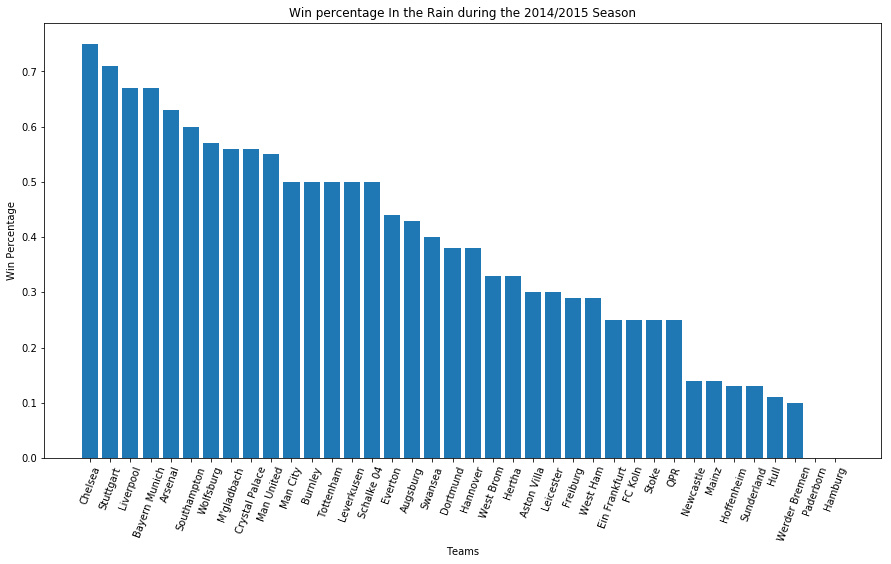

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))
df.sort_values('rain_win_pct', ascending=False, inplace=True)
ax.bar(df['Club'], df['rain_win_pct'])
ax.tick_params(axis='x', rotation=70)
ax.set_title('Win percentage In the Rain during the 2014/2015 Season')
ax.set_ylabel('Win Percentage')
ax.set_xlabel('Teams');

### Does the English Premier League have more goals per game than in Bundesliga in the 2011/12 season?

In [40]:
season_df = ds.get_season_data('database.sqlite', 2011)
season_df['total_goals'] = season_df['FTHG'] + season_df['FTAG']
season_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,total_goals
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,1
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,3
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,1
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,5
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,0


Mean Total Goals Scored per Game in D1: 2.86
Mean Total Goals Scored per Game in E0: 2.81


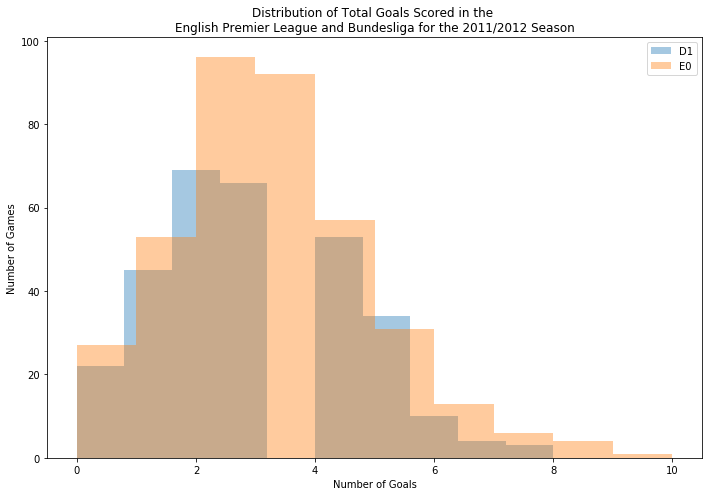

In [42]:
fig, ax = plt.subplots(figsize=(10, 7))

for division in season_df['Div'].unique():
    goal_counts = season_df[season_df['Div'] == division]['total_goals']
    ax.hist(goal_counts, bins=10, alpha=.4, label=division)
    print(f'Mean Total Goals Scored per Game in {division}: {goal_counts.mean():.2f}');
    
ax.legend()
ax.set_title('Distribution of Total Goals Scored in the \nEnglish Premier League and Bundesliga for the 2011/2012 Season')
ax.set_ylabel('Number of Games')
ax.set_xlabel('Number of Goals')
fig.tight_layout()

### Lets do a T-Test

Null Hypothesis: The total goals scored per game in the Premier League in the 2011/2012 season are the same or fewer than in Bundesliga

Alternative Hypothesis: The total goals scored per game in the Premier League in the 2011/2012 season are greater than in Bundesliga

I will set my alpha value to 0.1.


In [45]:
premier_goals = season_df[season_df['Div'] == 'E0']['total_goals']
bundesliga_goals = season_df[season_df['Div'] == 'D1']['total_goals']

scs.ttest_ind(premier_goals, bundesliga_goals, equal_var=False)

Ttest_indResult(statistic=-0.41952588185035455, pvalue=0.6749694728046564)

The test statistic is negative which means that bundesliga has more goals on average with a p value of 0.67.

A pvalue of 0.67 > 0.1 so we have failed to reject our null hypothesis